In [1]:
import pandas as pd
import altair as alt
import json

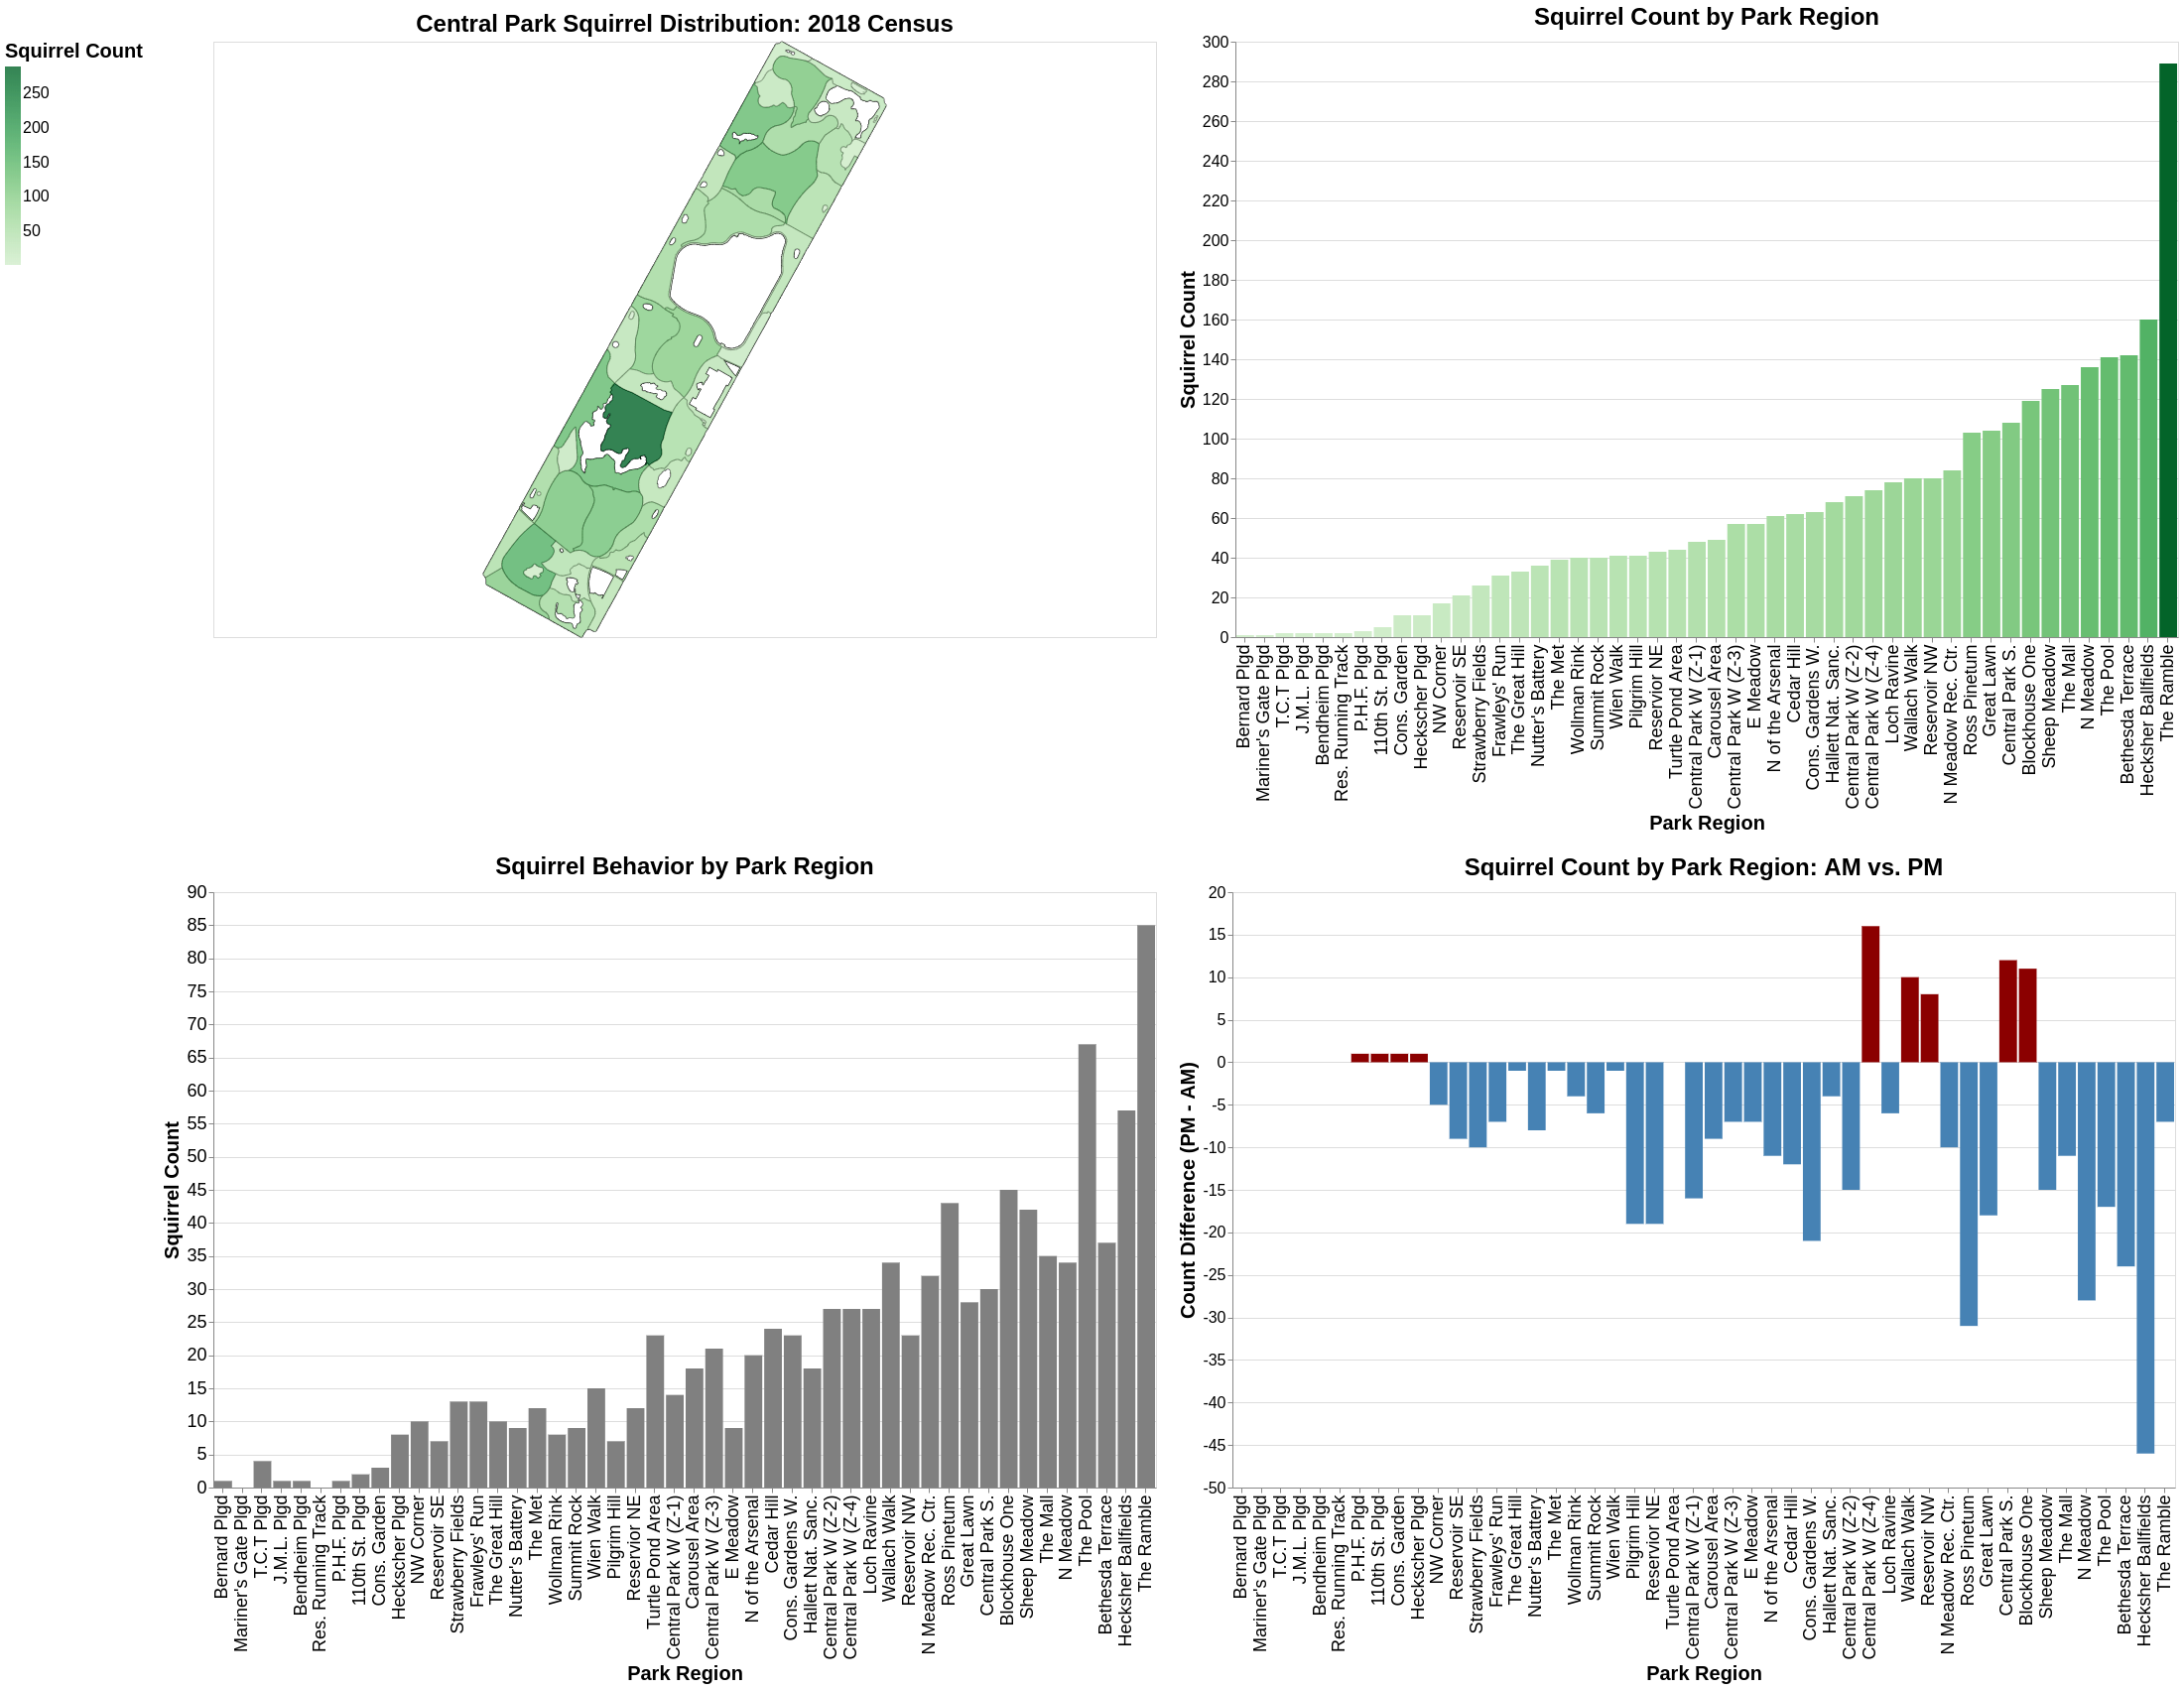

In [4]:
csv = pd.read_csv('../squirrel_count.csv')
sort_order = list(csv.sort_values(by = ['Unique_Squirrel_ID'])['sitename_short'])

with open('../data/squirrel_plots.json') as data_file:
    b_json_count = json.load(data_file)
squirrel_json = alt.Data(values = b_json_count['features'])

brush = alt.selection_multi(fields = ['properties.sitename_short'],
    resolve='global')


##################################
# PLOT MAP of SQUIRREL COUNT
##################################
def plot_map_total_count(selection):
    # Plot of squirrel count
    base_map = alt.Chart(squirrel_json).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=950,
        height=600
    )

    # Add Choropleth Layer
    choropleth = (alt.Chart(squirrel_json, 
                            title = "Central Park Squirrel Distribution: 2018 Census")
    .mark_geoshape()
    .add_selection(selection)
    .encode(
    # SELECTION SINGLE CONDITIONS -- Color is grey if not selected
        color = alt.condition(selection, 
                              'properties.Unique_Squirrel_ID:Q', 
                              alt.value('grey'),
            title = 'Squirrel Count',
            scale=alt.Scale(scheme='greens'),
            legend = alt.Legend(labelFontSize = 16, 
                                titleFontSize = 20, 
                                tickCount = 5,
                               orient = "left")),
        opacity=alt.condition(selection, 
                              alt.value(0.8), 
                              alt.value(0.1)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")]
    ))
    
    return(base_map + choropleth)


##########################################
# PLOT TOTAL SQUIRREL COUNT
##########################################
def plot_bar_total_count(selection):
    count_bar = (alt.Chart(squirrel_json, 
                           title = 'Squirrel Count by Park Region')
    .mark_bar()
    .add_selection(selection)
    .encode(
        x = alt.X('properties.sitename_short:N', 
                  title = "Park Region", 
                  axis = alt.Axis(labelFontSize = 18,
                                  titleFontSize = 20), 
                  sort = sort_order),
        y = alt.Y('properties.Unique_Squirrel_ID:Q', 
                  title = "Squirrel Count", 
                  axis = alt.Axis(labelFontSize = 16, 
                                  titleFontSize = 20)),
        color = alt.Color('properties.Unique_Squirrel_ID:Q',
                         scale=alt.Scale(scheme='greens'),
                         legend=None),

    # SELECTION SINGLE CONDITIONS -- opacity is 0.2 if not selected
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")])
    .properties(width = 950, height = 600))   
    return(count_bar)
plot_bar_total_count(brush)

################################################
# PLOT DIFFERENCE in COUNT by TIME OF DAY
################################################
def plot_bar_count_diff(selection):
    area_count_shift = (alt.Chart(squirrel_json)
    .mark_bar()
    .add_selection(selection)
    .encode(
        alt.X('properties.sitename_short:N',
              axis = alt.Axis(labelFontSize = 18,
                                           titleFontSize = 20), 
              title = "Park Region",
              sort = sort_order),
        alt.Y('properties.Count_diff (AM - PM):Q', 
              title = "Count Difference (PM - AM)", 
              axis = alt.Axis(labelFontSize = 16, 
                              titleFontSize = 20)),
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        color=alt.condition(
            # If count is negative, color bar blue. If positive, red.
            alt.datum['properties.Count_diff (AM - PM)'] > 0,
            alt.value("darkred"),  # The positive color
            alt.value("steelblue")  # The negative color
        ),
        tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                   alt.Tooltip('properties.Count_diff (AM - PM):Q', title="Count difference")]
    ).properties(title = "Squirrel Count by Park Region: AM vs. PM",
                 width = 950,
                height = 600))
    return(area_count_shift)
plot_bar_count_diff(brush)


# ###################################
# # PLOT BEHAVIOR by PARK AREA
# ###################################
def plot_bar_behavior(selection):
    b_chart = (alt.Chart(squirrel_json)
        .mark_bar(color = 'gray')
        #.add_selection(b_select)
        .add_selection(selection)
        .encode(alt.X('properties.sitename_short:N', title = "Park Region", sort = sort_order, axis = alt.Axis(labelFontSize = 18,
                                                   titleFontSize = 20)), 
                alt.Y('properties.Running_or_chasing:Q', title = 'Squirrel Count', axis = alt.Axis(labelFontSize = 18,
                                                   titleFontSize = 20)),
                opacity = alt.condition(brush, 
                                    alt.value(1.0), 
                                    alt.value(0.2)),
                tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                           alt.Tooltip('properties.Running_or_chasing:Q', title="Squirrel Count")]
               )
        #.transform_filter(b_select)
        .properties(title = "Squirrel Behavior by Park Region",
                     width = 950,
                    height = 600))
    return b_chart


# Create selection conditions and link plots by setting resolve = 'global'
brush = alt.selection_multi(fields = ['properties.sitename_short'],
    resolve='global'
)


# Render stacked plots
((plot_map_total_count(brush) | plot_bar_total_count(brush)) & (plot_bar_behavior(brush) | plot_bar_count_diff(brush))).configure_title(fontSize = 24)

# # source (code): https://www.districtdatalabs.com/altair-choropleth-viz